In [12]:
import tensorflow as tf
import numpy as np # version 1.16

# setup a virtual environment
# pipenv shell
# pip install tensorflow numpy==1.16 sklearn matplotlib

In [7]:

corpus_raw = 'He is the king . The king is royal . She is the royal  queen '

# convert to lower case
corpus_raw = corpus_raw.lower()

words = []
for word in corpus_raw.split():
    if word != '.': # because we don't want to treat . as a word
        words.append(word)

words = set(words) # so that all duplicate words are removed
word2int = {}
int2word = {}
vocab_size = len(words) # gives the total number of unique words

for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

# raw sentences is a list of sentences.
raw_sentences = corpus_raw.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())

WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence)) + 1] : 
            if nb_word != word:
                data.append([word, nb_word])

# function to convert numbers to one hot vectors
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

x_train = [] # input word
y_train = [] # output word

for data_word in data:
    x_train.append(to_one_hot(word2int[ data_word[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ data_word[1] ], vocab_size))

# convert them to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

# making placeholders for x_train and y_train
x = tf.placeholder(tf.float32, shape=(None, vocab_size))
y_label = tf.placeholder(tf.float32, shape=(None, vocab_size))

EMBEDDING_DIM = 5 # you can choose your own number
W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM])) #bias
hidden_representation = tf.add(tf.matmul(x,W1), b1)

W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) #make sure you do this!

# define the loss function:
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))

# define the training step:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)

n_iters = 10000
# train for n_iter iterations

for _ in range(n_iters):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})
    # print('loss is : ', sess.run(cross_entropy_loss, feed_dict={x: x_train, y_label: y_train}))

vectors = sess.run(W1 + b1)

def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index



In [8]:

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors) 

from sklearn import preprocessing

normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

# print(vectors)


{'king', 'he', 'royal', 'she', 'the', 'queen', 'is'}
king -0.05616011
he -0.90932214
royal -0.74210054
she 0.5162235
the -0.9930929
queen -0.5659706
is -0.7496585


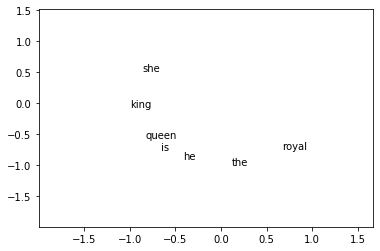

In [9]:

import matplotlib.pyplot as plt


fig, ax = plt.subplots()
print(words)
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
    ax.set_xlim(min([vectors[word2int[w]][0] for w in words])-1, max([vectors[word2int[w]][0] for w in words])+1)
    ax.set_ylim(min([vectors[word2int[w]][1] for w in words])-1, max([vectors[word2int[w]][1] for w in words])+1)
plt.show()
